# 02. Ice motion maps from OSI-SAF sea ice motion data
Data source: https://unep-viewer.mercator-ocean.eu/product/SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001/files?path=SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001%2FMETNO-GLO-SEAICE_DRIFT-NORTH-L4-NRT-OBS%2F&subdataset=osisaf_obs-si_glo_phy-sitype_nrt_sh-P1D_202107

Code by MacKenzie Jewell, edited by Noel Wang. Version in the FORK <br> every variable with a "w_" refers to the ice drift product from NSIDC (which is **w**eekly for 2024 only)

## Import packages

In [3]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *


# OSI SAF sea ice drift
from LIB_OSI_SAF import grab_projinfo_OSISAF, grab_OSISAF_drift

# NSIDC sea ice drift
from LIB_PPdrift_NSIDC0116 import grab_projinfo_PPdrift, grab_ice_Drift, convert_PPD_vectors


%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

#math
import math

#import shapely
import shapely
from shapely import Polygon, geometry
from shapely.geometry import Point

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set the date

In [9]:
# specify date to import
date_list = pd.date_range(datetime(2014, 1, 1), datetime(2014, 1, 1), freq="D")

#adjusting frequency to accomodate missing t2m 00:00 hour.
#============================

# specify range date1 -- date2
date1 = datetime(2013, 12, 25)
date2 = datetime(2014, 1, 25)

print(date2-date1)

31 days, 0:00:00


### NSDIC Weekly ice motion

In order to get the date range right, may have to use multiple datasets :/

/var/folders/1y/8_442fb923bb526xtrg6y2p80000gr/T/ipykernel_25336/4112292305.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds.indexes['time'].to_datetimeindex()


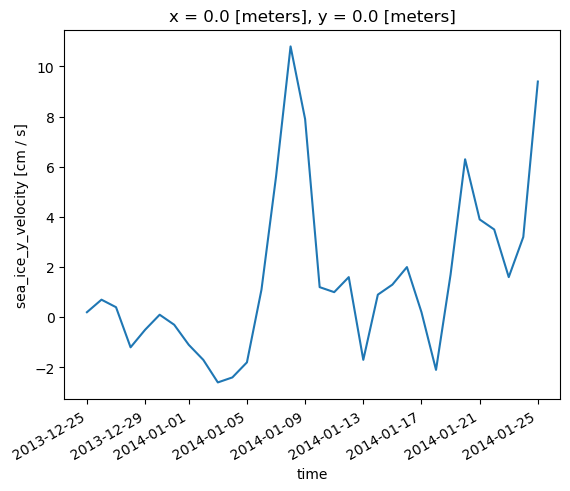

In [10]:
# create file path names using years of initial, final dates
path1 = f'/Volumes/Seagate2/NSIDC/icemotion_daily_nh_25km_{date1.year}_v4.1.nc'
path2 = f'/Volumes/Seagate2/NSIDC/icemotion_daily_nh_25km_{date2.year}_v4.1.nc'

# load both files into one dataset
ds = xr.open_mfdataset([path1, path2])
ds.close()

# convert time index from CF time to datetime
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex

# grab data slice from date1 to date2
# select v variable at point (180,180) to confirm data stretch across year change
ds.sel(time=slice(date1, date2)).v[:,180,180].plot()

In [54]:
# # figuring out date math

# # specify range date1 -- date2
# date1 = datetime(2003, 12, 1)
# date2 = datetime(2004, 1, 15)
# date1_num = date1.timetuple().tm_yday
# date2_num = 365+date2.timetuple().tm_yday+1

# print(f'date1num: {date1_num} and date2num: {date2_num}')

/var/folders/1y/8_442fb923bb526xtrg6y2p80000gr/T/ipykernel_25336/2984234001.py:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds.indexes['time'].to_datetimeindex()


u shape daily: (2, 10, 20)
2
2
2
DatetimeIndex(['2013-12-31', '2014-01-01'], dtype='datetime64[ns]', freq='D')


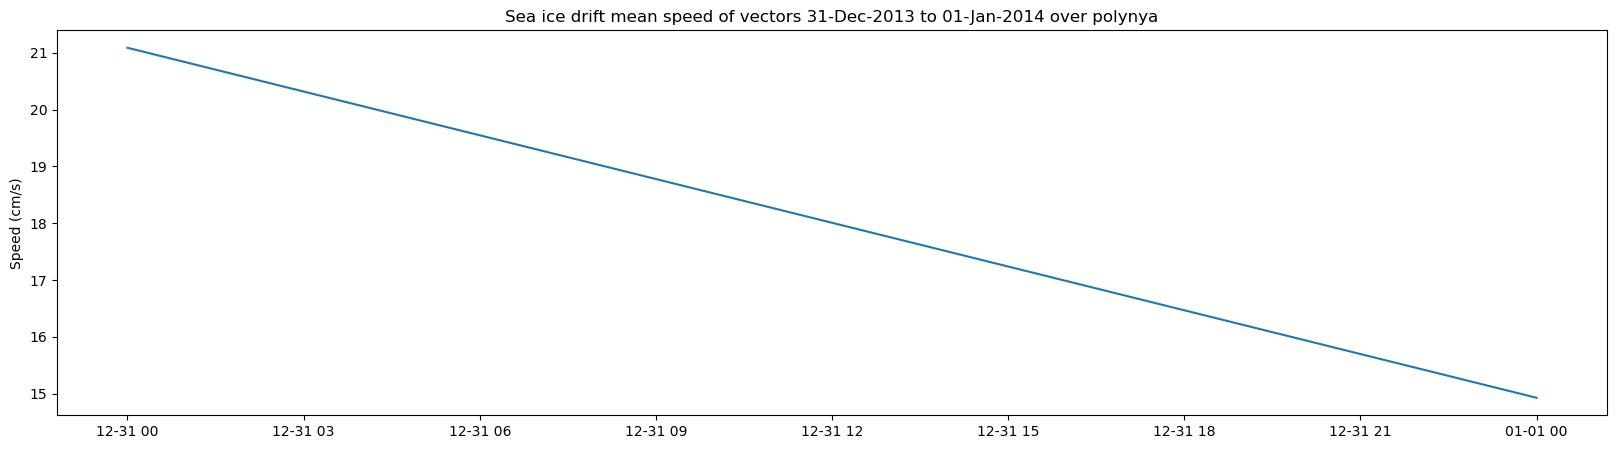

In [15]:
# Stitching over multiple years

main_path = '/Volumes/Seagate2/NSIDC/'
    
# specify range date1 -- date2
date1 = datetime(2013, 12, 31)
date2 = datetime(2014, 1, 1)
date_list = pd.date_range(date1, date2, freq="D")
date1_num = date1.timetuple().tm_yday
date2_num = 365+date2.timetuple().tm_yday+1 #horrible date math haha

# create file path names using years of initial, final dates
path1 = f'/Volumes/Seagate2/NSIDC/icemotion_daily_nh_25km_{date1.year}_v4.1.nc'
path2 = f'/Volumes/Seagate2/NSIDC/icemotion_daily_nh_25km_{date2.year}_v4.1.nc'

# load both files into one dataset
if date1.year != date2.year:
    ds = xr.open_mfdataset([path1, path2])
else:
    ds = xr.open_dataset(path1)
ds.close()

# convert time index from CF time to datetime
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex

# ds_date = ds.sel(time = date)

NSIDC = {}

NSIDC['time'] = ds.date.time.values
NSIDC['x'] = ds.date.x.values
NSIDC['y'] = ds.date.y.values
NSIDC['u'] = ds.date.u.values
NSIDC['v'] = ds.date.v.values
NSIDC['proj'] = grab_projinfo_PPdrift(ds)

#spatial cropping for NSIDC
w_x_cr = (120, 140)
w_y_cr = (245, 255)

#for daily data
ds.u[date1_num:date2_num, w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]].shape
daily_u = np.nanmean(ds.u[date1_num:date2_num, w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]], axis=(1,2))
daily_v = np.nanmean(ds.v[date1_num:date2_num, w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]], axis=(1,2))
daily_uv = np.sqrt(daily_u**2 + daily_v**2)
# print(NSIDC['time'][week])

print(f'u shape daily: {ds.u[date1_num:date2_num, w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]].shape}')


# # # convert_PPD_vectors(lon=ds.longitude.values, u_EASE=weekly_u, )

fig, ax = plt.subplots(figsize = (20, 5))
plt.plot(date_list, np.sqrt(daily_u**2 + daily_v**2))

plt.title(f'Sea ice drift mean speed of vectors {date_list[0].strftime("%d-%b-%Y")} to {date_list[-1].strftime("%d-%b-%Y")} over polynya')
ax.set_ylabel("Speed (cm/s)")

print(len(daily_uv))
print(len(daily_u))
print(len(daily_v))
print((date_list))

In [19]:
NSIDC['u'][0].shape

(361, 361)

In [20]:
ds

<xarray.Dataset>
Dimensions:                   (x: 361, y: 361, time: 730)
Coordinates:
  * x                         (x) float64 -4.512e+06 -4.487e+06 ... 4.512e+06
  * y                         (y) float64 -4.512e+06 -4.487e+06 ... 4.512e+06
  * time                      (time) datetime64[ns] 2013-01-01 ... 2014-12-31
Data variables:
    crs                       (time) int32 -2147483647 ... -2147483647
    u                         (time, y, x) float32 dask.array<chunksize=(365, 361, 361), meta=np.ndarray>
    v                         (time, y, x) float32 dask.array<chunksize=(365, 361, 361), meta=np.ndarray>
    icemotion_error_estimate  (time, y, x) float32 dask.array<chunksize=(365, 361, 361), meta=np.ndarray>
    latitude                  (time, y, x) float32 dask.array<chunksize=(365, 361, 361), meta=np.ndarray>
    longitude                 (time, y, x) float32 dask.array<chunksize=(365, 361, 361), meta=np.ndarray>
Attributes:
    version:       4.1
    release_date:  April 2019
    Conventions:   CF-1.4
    citation:      Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhan...
    dataset_doi:   10.5067/INAWUWO7QH7B

In [33]:
# read in SIC projeciton
# read daily sic data from computer files into dictionary
data = grab_ASI_SIC(date=datetime(2020,1,1), 
    main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
    coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
    hemisphere='n', resolution='6250', version='v5.4', 
    return_vars=['proj'], 
    include_units=False, annual_folders=False, return_dict = True, quiet=True)

#making the mask

df = pd.read_csv("/Users/reu/Box/Data/mask2.csv")
listx2 = df.xlist.values
listy2 = df.ylist.values

polygon2 = geometry.Polygon([[x, y] for x,y in zip(listx2, listy2)])

mask2 = np.full(NSIDC['u'][0].shape, False)

for ii in range (mask2.shape[0]):
    for jj in range (mask2.shape[1]):
        
        trans_point = data['proj'].transform_point(NSIDC["x"][jj], NSIDC["y"][ii], NSIDC['proj'])
        point2 = Point(trans_point)
        mask2[ii, jj] = polygon2.contains(point2)

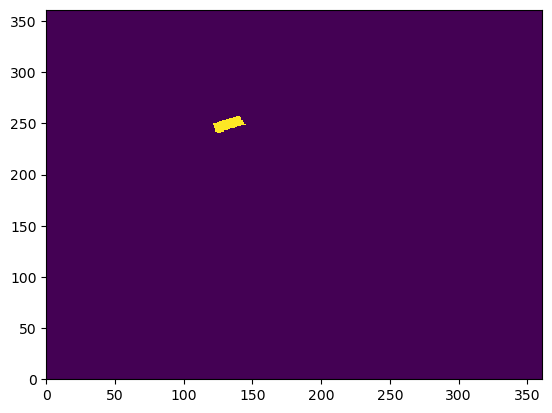

In [34]:
plt.pcolormesh(mask2)

### when the dataset does NOT have multiple years

In [3]:
main_path = '/Volumes/Seagate2/NSIDC/'

ds = xr.open_dataset(main_path + f'icemotion_daily_nh_25km_20110101_20111231_v4.1.nc') #must change this manually
ds.close

NSIDC = {}

NSIDC['time'] = ds.time.values
NSIDC['x'] = ds.x.values
NSIDC['y'] = ds.y.values
NSIDC['u'] = ds.u.values
NSIDC['v'] = ds.v.values
NSIDC['proj'] = grab_projinfo_PPdrift(ds)

#========
week = 52
#========

print(NSIDC['time'][week])

weekly_times = ds.time[52:57].values
weekly_datetimes = [datetime.strptime(weekly_time.isoformat(), '%Y-%m-%dT00:00:00') for weekly_time in weekly_times]

daily_times = ds.time[0:31].values #days 0-31 of the dataset
daily_datetimes = [datetime.strptime(daily_time.isoformat(), '%Y-%m-%dT00:00:00') for daily_time in daily_times]

# print(weekly_times)
print(daily_times)


#spatial cropping
w_x_cr = (120, 140)
w_y_cr = (245, 255)

#for weekly data
ds.u[52:57, w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]].shape
weekly_u = np.nanmean(ds.u[52:57, w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]], axis=(1,2))
weekly_v = np.nanmean(ds.v[52:57, w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]], axis=(1,2))
weekly_uv = np.sqrt(weekly_u**2 + weekly_v**2)

#for daily data
ds.u[0:31, w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]].shape
daily_u = np.nanmean(ds.u[0:31, w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]], axis=(1,2))
daily_v = np.nanmean(ds.v[0:31, w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]], axis=(1,2))
daily_uv = np.sqrt(daily_u**2 + daily_v**2)

# # convert_PPD_vectors(lon=ds.longitude.values, u_EASE=weekly_u, )

# fig, ax = plt.subplots(figsize = (20, 5))
# plt.step(weekly_datetimes, np.sqrt(weekly_u**2 + weekly_v**2), where='post')



# plt.title(f'Sea ice drift mean speed of vectors {weekly_datetimes[0].strftime("%d-%b-%Y")} to {weekly_datetimes[-1].strftime("%d-%b-%Y")} over polynya')
# ax.set_ylabel("Speed (km/day)")

print(len(daily_uv))
print(len(daily_u))
print(len(daily_v))
print(len(date_list))

2011-02-22 00:00:00
[cftime.DatetimeJulian(2011, 1, 1, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 2, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 3, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 4, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 5, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 6, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 7, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 8, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 9, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 10, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 11, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 12, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 13, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2011, 1, 14, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(

## export to CSV

In [76]:
d = {'time': date_list, 'daily_u_cm_s': daily_u, 'daily_v_cm_s': daily_v, 'daily_uv_cm_s': daily_uv}
df = pd.DataFrame(data=d)
df.to_csv(f'/Users/reu/Box/Data/{date_list[-1].strftime('%Y')}daily_drift.csv', index=None) #removes Index column

In [ ]:
ds
ds['xc'].shape

### OSI-SAF sea ice drift

In [ ]:

# specify date to import
#============================
date = datetime(2024, 1, 14)
#============================

#takes the middle day (peep documentation)

OSISAF = grab_OSISAF_drift(date = date, 
                          main_path = '/Volumes/Seagate2/OSI_SAF_Drift/')

In [47]:
moo = np.arange(1, 32, 1, dtype=int)
print(moo)
len(date_list)

datetester = datetime(2011, 2, 24)
print(datetester.timetuple().tm_yday)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
55


## Make map

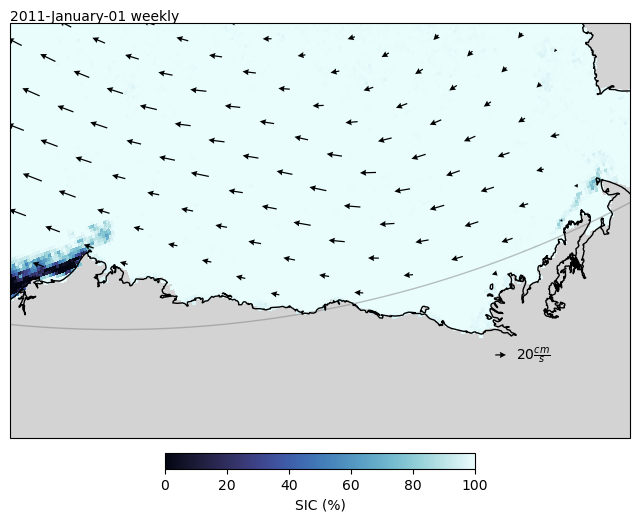

In [48]:

# specify date to import
date = datetime(2011, 1, 1)
day = date.timetuple().tm_yday

#adjusting frequency to accomodate missing t2m 00:00 hour.
#============================    
    
# read daily sic data from computer files into dictionary
data = grab_ASI_SIC(date=date, 
            main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
            coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
            hemisphere='n', resolution='6250', version='v5.4', 
            return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
            include_units=False, annual_folders=False, return_dict = True, quiet=True)

# create figure
#--------------
# create map figure in north polar stereographic projection
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=map_projection))

# background color
ax.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
ax.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree())  

# add coastlines
ax.coastlines(zorder=100)

# lat / lon lines
add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)


# plot 2d sic data 
icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
                     cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.5, pad=0.025)


# label date
ax.text(0, 1, f'{date.strftime('%Y-%B-%d')} weekly', ha='left', va='bottom', transform=ax.transAxes, clip_on=False)


# OSISAF sea ice drift
# qv1 = ax.quiver(OSISAF['x'], OSISAF['y'], OSISAF['dx']/2, OSISAF['dy']/2, 
#                color = 'gray', width = 0.002, headwidth=5, scale = 500, transform = OSISAF['proj'], zorder=5)
# qk = ax.quiverkey(qv1, 0.9, 0.1, 20, r'$20 \frac{km}{day}$', labelpos='E',transform=ccrs.PlateCarree(),)


# NSIDC sea ice drift. Relabel if using.
sp = 3
qv2 = ax.quiver(NSIDC['x'][::sp], NSIDC['y'][::sp], NSIDC['u'][day,:,:][::sp,::sp], NSIDC['v'][day,:,:][::sp,::sp], 
               color = 'k', width = 0.002, headwidth=5, scale = 1000*1.15741, transform = NSIDC['proj'], zorder=5)
qk = ax.quiverkey(qv2, 0.8, 0.2, 20, r'$20 \frac{cm}{s}$', labelpos='E',transform=ccrs.PlateCarree(),)


plt.show()


## save figure, if desired
# save_path = f'/Users/jewell/Desktop/weekly_map_{date.strftime("%Y-%m-%d")}.png'
# fig.savefig(save_path, dpi=300, bbox_inches = 'tight')

## Create timeseries

In [ ]:
# NSIDC

date = datetime(2024, 1, 1)
ds2 = xr.open_dataset("/Volumes/Seagate2/NSIDC/icemotion_weekly_nh_25km_20230101_20240630_ql.nc")


In [24]:

# all_speeds = np.array([])
list_speed_of_mean_vector = []
list_mean_speed_of_vector = []
w_list_speed_of_mean_vector = []
w_list_mean_speed_of_vector = []
angles_list = []
all_dates = pd.date_range(start='2024-1-1', end='2024-1-30', freq='D')

x_cr = (22, 33) # bottom, top
y_cr = (83, 92) #left, right


for date in all_dates:

    OSISAF = grab_OSISAF_drift(date = date, 
                          main_path = '/Volumes/Seagate2/OSI_SAF_Drift/')
    # NSIDC = grab_ice_Drift(date = date, 
    #                       PPD_drift_path = '/Volumes/Seagate2/NSIDC/', PPD_filename = 'icemotion_weekly_nh_25km_20230101_20240630_ql.nc', return_vars = ['lon', 'lat', 'u', 'v', 'xx', 'yy', 'u_EASE', 'v_EASE', 'proj', 'ds', 'error'], 
    #                       lat_range = [0, 90], lon_range = [0, 360])
    
    #cropping OSI SAF data
    crop_dx = OSISAF['dx'][y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]/2
    crop_dy = OSISAF['dy'][y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]/2
    speed_of_mean_vector = np.sqrt(np.nanmean(crop_dx)**2 + np.nanmean(crop_dy)**2)
    mean_speed_of_vector = np.nanmean(np.sqrt((crop_dx)**2 + (crop_dy)**2))
    list_speed_of_mean_vector.append(speed_of_mean_vector)
    list_mean_speed_of_vector.append(mean_speed_of_vector)
    
    #angle
    angle = math.atan((np.nanmean(crop_dx))/np.nanmean(crop_dy)
             )
    angles_list.append(math.degrees(angle))

print(len(list_mean_speed_of_vector))


30


In [ ]:
print(len(w_list_mean_speed_of_vector))

** use geometry to find the average direction :)

In [23]:
x_grid, y_grid = np.meshgrid(OSISAF['x'], OSISAF['y'])

x_grid.shape
OSISAF["dx"].shape

(177, 119)

In [19]:
w_x_grid, w_y_grid = np.meshgrid(NSIDC['x'], NSIDC['y'])
w_x_grid.shape
NSIDC['u'].shape

print(f'wx grid shape: {w_x_grid.shape} and wy grid shape: {w_y_grid.shape}')

wx grid shape: (361, 361) and wy grid shape: (361, 361)


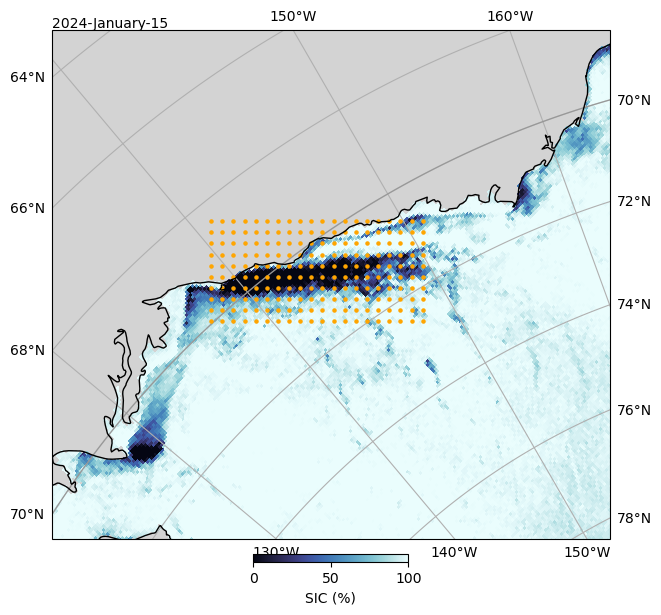

In [20]:
#figuring out cropping for NSIDC data

date = datetime(2024, 1, 15)

OSISAF.keys()
# fig2, ax2 = plt.subplots(figsize = (10, 10))

# create map figure in north polar stereographic projection
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=NSIDC['proj']))

# background color
ax.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
ax.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree()) 

ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

# add coastlines
ax.coastlines(zorder=100)


# read daily sic data from computer files into dictionary
data = grab_ASI_SIC(date=date, 
                main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
                coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
                hemisphere='n', resolution='6250', version='v5.4', 
                return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
                include_units=False, annual_folders=False, return_dict = True, quiet=True)

# create figure
#--------------
# create map figure in north polar stereographic projection

# add land
add_land(ax, scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=0)

# lat / lon lines
add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)

# plot 2d sic data 
icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
                        cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'], zorder = 1)

#color bar
plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.25, pad=0.025)

# label date
ax.text(0, 1, date.strftime('%Y-%B-%d'), ha='left', va='bottom', transform=ax.transAxes, clip_on=False)

w_x_cr = (120, 140)
w_y_cr = (245, 255)

sp = 1
#ax.scatter(w_x_grid[::sp, ::sp], w_y_grid[::sp, ::sp], transform = NSIDC['proj'], s=5, zorder = 2, color = 'orange')
#ax.scatter(w_x_grid[1, 20], w_y_grid[200, 250], transform = NSIDC['proj'], s=5, zorder = 2, color = 'orange')

ax.scatter(w_x_grid[w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]], w_y_grid[w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]], transform = NSIDC['proj'], s=5, zorder=2, color='orange')


In [ ]:
w_x_grid.shape


### plotting daily drift in native coords

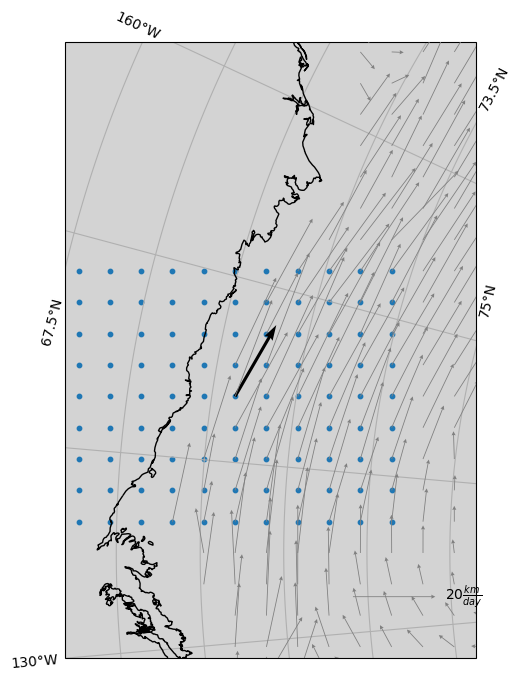

In [26]:
OSISAF.keys()
# fig2, ax2 = plt.subplots(figsize = (10, 10))

# create map figure in north polar stereographic projection
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig2, ax2 = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=OSISAF['proj']))

# background color
ax2.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
ax2.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree()) 

ax2.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

ax2.scatter(x_grid[y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]], y_grid[y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]], transform = OSISAF['proj'], s=10)

#ax2.scatter(w_x_grid[::sp, ::sp], w_y_grid[w_y_cr[0]:w_y_cr[1], w_x_cr[0]:w_x_cr[1]], transform = OSISAF['proj'], s=10)
# ax.scatter(data['xx'][::sp, ::sp], data['yy'][::sp, ::sp], transform=data['proj'])

# add coastlines
ax2.coastlines(zorder=100)


# OSISAF sea ice drift
qv1 = ax2.quiver(OSISAF['x'], OSISAF['y'], OSISAF['dx']/2, OSISAF['dy']/2, 
               color = 'gray', width = 0.002, headwidth=5, scale = 100, transform = OSISAF['proj'], zorder=5)
qk = ax2.quiverkey(qv1, 0.9, 0.1, 20, r'$20 \frac{km}{day}$', labelpos='E',transform=ccrs.PlateCarree(),)


#figure out the angle ~60°
qv2 = ax2.quiver(np.mean(x_grid[y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]), np.mean(y_grid[y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]), 0.5, math.sqrt(3)/2, scale = 5, transform = OSISAF['proj'])

In [27]:
OSISAF['proj']
print(all_speeds)
print(region_speed)
print(sum(angles_list) / len(angles_list))

NameError: name 'all_speeds' is not defined

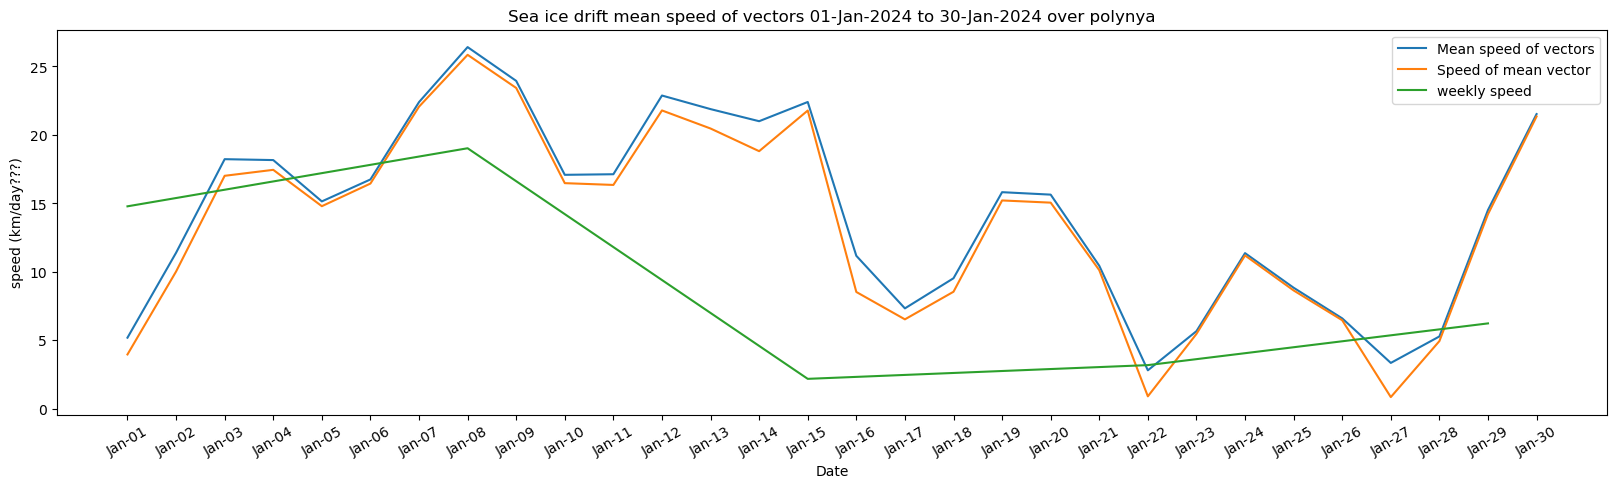

In [28]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(all_dates, list_mean_speed_of_vector, label = "Mean speed of vectors")
ax.plot(all_dates, list_speed_of_mean_vector, label = "Speed of mean vector")
ax.plot(weekly_datetimes, weekly_uv*.864, label = "weekly speed") #converting cm/s to km/day

#legend
ax.legend()

#ax.axhline(10, c='k', linestyle='dashed')

#formatting the plot
plt.xticks(rotation=30)
plt.xticks(all_dates)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
#labels
plt.xlabel('Date')
# ax.set_ylabel('sea ice speed (km/day)')

ax.set_ylabel('speed (km/day???)')

plt.title(f'Sea ice drift mean speed of vectors {all_dates[0].strftime("%d-%b-%Y")} to {all_dates[-1].strftime("%d-%b-%Y")} over polynya')

d = {'time': weekly_datetimes, 'weekly_avg_u (cm/s)': weekly_u, 'weekly_avg_v (cm/s)': weekly_v, 'weekly_avg_uv': weekly_uv}
datafile = pd.DataFrame(data=d)
datafile.to_csv('/Users/reu/Box/Data/weekly_speeds_drift.csv', index=None) #removes Index column


# df = pd.read_csv('./Data/speeds_ice.csv')

## Export as CSV

In [29]:


d = {'time': all_dates, 'speed_of_mean': list_speed_of_mean_vector, 'mean_of_speed': list_mean_speed_of_vector}
df = pd.DataFrame(data=d)
df.to_csv('./Data/speeds_ice.csv', index=None) #removes Index column





df = pd.read_csv('./Data/speeds_ice.csv')
df['time'] = pd.to_datetime(df.time)

fig3, ax3 = plt.subplots(figsize=(20,5))

#formatting the plot
plt.xticks(rotation=30)
plt.xticks(all_dates)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

plt.plot(df.time, df.speed_of_mean)


OSError: Cannot save file into a non-existent directory: 'Data'

## code graveyard

In [ ]:
newList = ['apple', 'orange', 'peach']
newList.pop(-1)
print(newList)

In [ ]:
pd.to_datetime(df.time)

### Creating graphs of arrows